In [65]:
D <- read.csv("DST_BIL54.csv")
D$time <- as.POSIXct(paste0(D$time,"-01"), "%Y-%m-%d", tz="UTC")
## Year to month for each of them
D$year <- 1900 + as.POSIXlt(D$time)$year + as.POSIXlt(D$time)$mon / 12
## Make the output variable a floating point (i.e.\ decimal number)
D$total <- as.numeric(D$total) / 1E6
## Divide intro train and test set
teststart <- as.POSIXct("2024-01-01", tz="UTC")
Dtrain <- D[D$time < teststart, ]
Dtest <- D[D$time >= teststart, ]

In [66]:
Recursiveestimation <- function(lambda,k) {D <- read.csv("DST_BIL54.csv")
D$time <- as.POSIXct(paste0(D$time,"-01"), "%Y-%m-%d", tz="UTC")
## Year to month for each of them
D$year <- 1900 + as.POSIXlt(D$time)$year + as.POSIXlt(D$time)$mon / 12
## Make the output variable a floating point (i.e.\ decimal number)
D$total <- as.numeric(D$total) / 1E6
## Divide intro train and test set
teststart <- as.POSIXct("2024-01-01", tz="UTC")
Dtrain <- D[D$time < teststart, ]
Dtest <- D[D$time >= teststart, ]
xx <- D$year 
y <- D$total
x <-cbind(1,xx)

## define lambda(t)
#lambda_t <- function(t,l,N){return(l^(N-t))}
N <-length((y))

parameter_list <- matrix(NA, nrow=N, ncol=2)
prediction_list <- matrix(NA, nrow=N, ncol=1)
error_list <- matrix(NA, nrow=N, ncol=1)

R_1 <- x[1,]%*%t(x[1,])
h_1 <- x[1,]*y[1]

R_2 <- lambda*R_1 + x[2,] %*% t(x[2,])
h_2 <- lambda*h_1 + x[2,] * y[2]

h_3 <- lambda*h_2 + x[3,] * y[3]
R <- lambda*R_2 + x[3,] %*% t(x[3,])
parameter_list[3,] <- solve(R) %*% h_3

for (i in 4:N) {
R <- R * lambda + x[i,] %*% t(x[i,])  # Update R
parameter_list[i,] <- parameter_list[i-1,] + (solve(R) %*% x[i,]) %*% (y[i] - t(x[i,]) %*% parameter_list[i-1,])  # Update parameter
if (i+k<N){prediction_list[i+k] <- x[i+k,]%*%parameter_list[i,]}
if (i+k<N){error_list[i+k]<-prediction_list[i+k]-y[i+k]}
}
return(list(par=parameter_list[,1],pre=prediction_list,err=error_list))
}


In [67]:
length(Recursiveestimation(0.7,1)$pre[73:84])


[1] 12

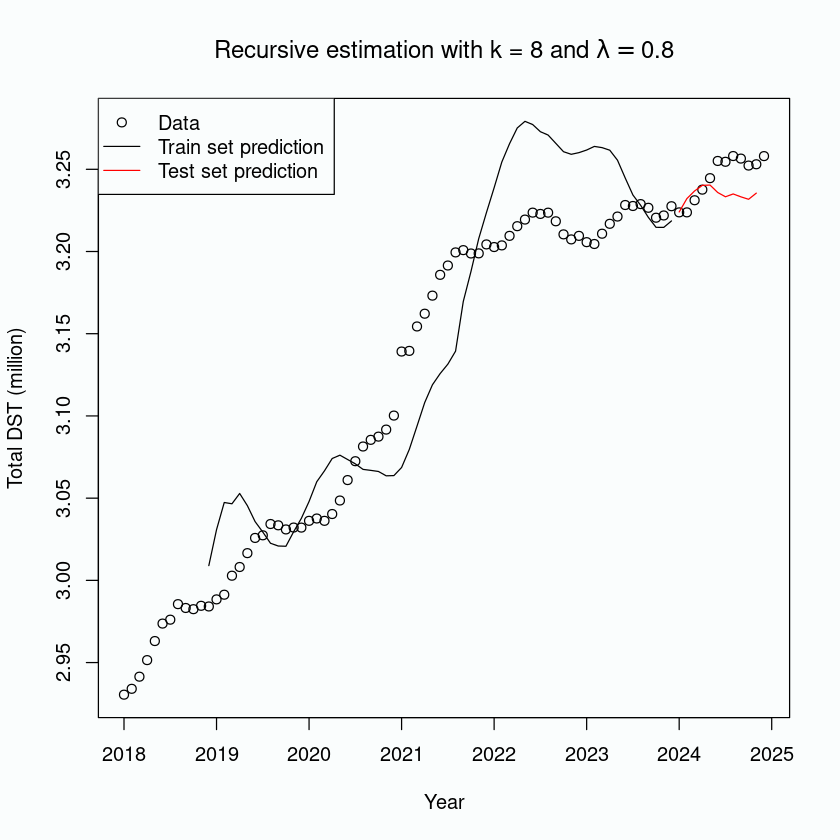

In [77]:
par(bg = "#fafdfd")
#plot until the last year of the test set
k = 8
lam = 0.8

plot(Dtrain$year,Recursiveestimation(lam,k)$pre[1:length(Dtrain$year)],
type = 'l',
col = "#000000",xlab = "Year",ylab = "Total DST (million)",
main = bquote("Recursive estimation with k = " * .(k) * " and " * lambda == .(lam)),
xlim = c(D$year[1],D$year[length(D$year)]),
ylim = c(D$total[1],max(D$total[length(D$year)],max(Recursiveestimation(lam,k)$pre[1:84],na.rm = TRUE)))

)
points(D$year,D$total)
points(Dtest$year,type = 'l',Recursiveestimation(lam,k)$pre[73:84],col = "red")
legend("topleft",legend = c("Data","Train set prediction","Test set prediction"),
col = c("black","black","red"),lty = c(NA,1,1),pch = c(1,NA,NA))